# Transformation visuelle pour reconstruction d'image corporelle

## Objectifs
L'objectif est d'améliorer le code de network2_01.py. 
Plusieurs pistes d'amélioration sont possibles:
1. Utiliser un produit tensoriel plutôt qu'un produit terme à terme.
2. Différencier la cible de la main.
3. Intégerer tf.
4. changer la répartition des points. 

Je m'inspire du papier de Memisevic, Gradient-based learning of higher-order image features et de son code gatedAutoencoder.py.

## Imports et setup





In [1]:
from numpy import *
from matplotlib.pylab import *
from mpl_toolkits.mplot3d import Axes3D
from drawnow import *
from skimage.draw import line, line_aa

import time 
import random
import scipy
import math
import cv2
import cPickle as pickle
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
matplotlib.rcParams.update({'font.size':16})
to_backup = True
timeframe = time.strftime('%Y%m%d%H%M%S')
L1 = 32
L2 = 16
L3 = 8

nb_posture = 30
nb_command = 10
nb_joint = 3
nb_data = nb_command*nb_posture

## Construction de la base de données

1. On génère n postures différentes aléatoirement, X.
2. On génère m commandes aléatoirement, H. 
3. On applique chaque commande à chaque posture et on obtient des nouvelles postures Y.

### Génération des postures initiales

In [3]:
def randrange(n , vmin, vmax):
    return (vmax-vmin)*rand(n) + vmin 

In [4]:
posture = zeros((nb_posture, 3))
posture[:,0] = randrange(nb_posture, 0, pi)
posture[:,1] = randrange(nb_posture, 0, pi)
posture[:,2] =randrange(nb_posture, 0, pi)

In [5]:
print(shape(posture))
print(posture[0])

(30, 3)
[2.33094134 2.21956547 1.59965285]


### Génération des commandes 

In [6]:
command = zeros((nb_command, 3))
command[:,0] = randrange(nb_command, 0, 1)
command[:,1] = randrange(nb_command, 0, 1)
command[:,2] =randrange(nb_command, 0, 1)

In [7]:
print(shape(command))
print(command[0])
print(randint(0,nb_command-1))

(10, 3)
[0.78467481 0.37295959 0.94580665]
7


### Génération des données d'entraînement

In [8]:
train_data_x = zeros((nb_data, 1, 3))
train_data_y = zeros((nb_data, 1, 3))
train_data_h = zeros((nb_data, 1, 3))

In [9]:
print(train_data_x[0][0])
print(shape(train_data_x))

[0. 0. 0.]
(300, 1, 3)


In [10]:
idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_x[idx] = posture[i]
        idx = idx + 1

idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_y[idx] = posture[i]  + command[j]
        idx = idx + 1
        
idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_h[idx] = command[j]
        idx = idx + 1

In [11]:
print('train_data_x 0 0 ', train_data_x[0][0])
print('train_data_h 0 0 ', train_data_h[0][0])
print('train_data_y 0 0 ', train_data_y[0][0])
print('y = x + h')

('train_data_x 0 0 ', array([2.33094134, 2.21956547, 1.59965285]))
('train_data_h 0 0 ', array([0.78467481, 0.37295959, 0.94580665]))
('train_data_y 0 0 ', array([3.11561615, 2.59252506, 2.5454595 ]))
y = x + h


### Génération des images associées

In [12]:
train_images_x = zeros((nb_data, 1, 128, 128), dtype = uint8)
train_images_y = zeros((nb_data, 1, 128, 128), dtype = uint8)

In [13]:
for i in range(nb_data):
    img = zeros((128,128), dtype = uint8)
    angle = train_data_x[i][0] 
    row1, col1 = 64 + int(floor(L1*sin(angle[0]))), 64 + int(floor(L1*cos(angle[0])))
    row2, col2 =  int(floor(L2*sin(angle[1]))) + row1, col1 + int(floor(L2*cos(angle[1])))
    row3, col3 = int(floor(L3*sin(angle[2])))+ row2, col2 +  int(floor(L3*cos(angle[2])))
    r1, c1, val1 = line_aa(64,64,row1, col1)
    r2, c2, val2 = line_aa(row1, col1, row2, col2)
    r3, c3, val3 = line_aa(row2, col2, row3 , col3)
    img[r1,c1] = val1*255
    img[r2,c2] = val2*255
    img[r3,c3] = val3*255
    train_images_x[i][0] = img 

for i in range(nb_data):
    img = zeros((128,128), dtype = uint8)
    angle = train_data_y[i][0] 
    row1, col1 = 64 + int(floor(L1*sin(angle[0]))), 64 + int(floor(L1*cos(angle[0])))
    row2, col2 =  int(floor(L2*sin(angle[1]))) + row1, col1 + int(floor(L2*cos(angle[1])))
    row3, col3 = int(floor(L3*sin(angle[2])))+ row2, col2 +  int(floor(L3*cos(angle[2])))
    r1, c1, val1 = line_aa(64,64,row1, col1)
    r2, c2, val2 = line_aa(row1, col1, row2, col2)
    r3, c3, val3 = line_aa(row2, col2, row3 , col3)
    img[r1,c1] = val1*255
    img[r2,c2] = val2*255
    img[r3,c3] = val3*255
    train_images_y[i][0] = img 

On peut rajouter une gaussienne au bout de l'effecteur pour le mettre en évidence
TODO

In [15]:

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """
    x = arange(0, size, 1, float)
    y = x[:,newaxis]
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]    
    return exp(-4*log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)


### Exemples d'images

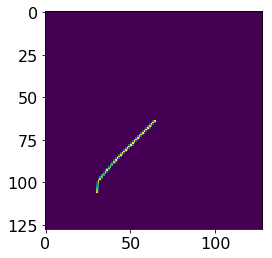

In [18]:
imshow(train_images_x[0][0])

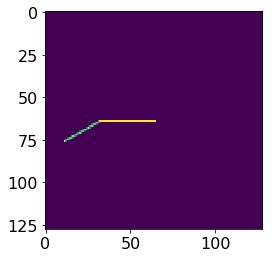

In [19]:
imshow(train_images_y[0][0])

## Factorized Gated Field Auto-encoder